<a href="https://colab.research.google.com/github/cvankir2/GenreClassification/blob/main/RNN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Genre Classification using RNN Model

This code does the preprocessing, model compiling, training, and testing for music genre classification. It takes the top three probabilities for songs and generates accuracies based on that. The data preprocessing takes mp3 files and converts it into MFCC numpy arrays, which are then truncated to the same size and passed into the RNN for classification.

Audio was taken from this github link: https://github.com/mdeff/fma

In [1]:
!pip install utils  --quiet
!pip install python-dotenv  --quiet
!pip install pydub --quiet
!pip install ffmpeg --quiet
!pip install librosa --quiet
!pip install tensorflow --quiet

In [2]:
# Imports 

import numpy as np
import os
from progressbar import ProgressBar

# for preprocessing
from sklearn.preprocessing import LabelEncoder

# for training and analysis
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import argparse

# for loading and visualizing audio files
import librosa
import librosa.display

# to play audio
import IPython.display as ipd

In [3]:
from google.colab import drive
drive.mount('/content/Shareddrives', force_remount = True)

Mounted at /content/Shareddrives


In [4]:
cd Shareddrives/Shareddrives/'Neural Networks Project!'

/content/Shareddrives/Shareddrives/Neural Networks Project!


In [5]:
from fma import utils

# Preprocessing Data 
Here we take the mp3 files from the Data folder and convert them to MFCC numpy files and save them to the MFCCs folder. The numpy arrays are then combined into one list, sizes are adjusted to all match, and the labels are generated with corresponding numbers

In [ ]:
# Converting MP3 files to MFCC numpy files
def mp3_to_mfcc(id):
  sid = str(id).zfill(6)

  data_path = f"Data/{sid}.mp3"
  new_path = f"MFCCS/{sid}.npy"

  # if the MFCC file exists already, pass
  if os.path.isfile(new_path):
    return 
  try:
    # load the mp3 file and use librosa to convert it to mfccs
    y, sr = librosa.load(data_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, n_fft=2048, hop_length=512)
    np.save(new_path, mfccs)
  except Exception as e:
    return

In [ ]:
tracks = utils.load('Data/tracks.csv')
genre = tracks['track']['genre_top']

In [ ]:
pbar = ProgressBar()

for track_id in pbar(tracks.index):
  mp3_to_mfcc(track_id)


In [ ]:
# testing that it worked
data = np.load('MFCCS/026659.npy')
print("shape of data:", data.shape)
print(data)

shape of data: (20, 1291)
[[-5.1563843e+02 -5.1563843e+02 -5.1563843e+02 ... -1.2251836e+02
  -1.5924551e+02 -1.4019069e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.1554545e+02
   1.2829832e+02  9.2459732e+01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.6647310e+01
  -2.0370483e-02  3.5040840e+01]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.1909382e+00
   6.1139035e-01  6.4555740e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.1254101e+00
  -1.0346215e+00 -7.7279387e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.1366878e+00
  -1.2427211e+00  2.8496630e+00]]


In [ ]:
# helper function to check if the file will be included in the dataset
def is_valid(id):
  path = f"MFCCS/{id}.npy"

  if os.path.isfile(path):
    return True
  else:
    return False

In [ ]:
# Prepare the labels and data to be passed into the RNN model
labels = []
data = []
pbar = ProgressBar()
for track_id in pbar(tracks.index):
  sid = str(track_id).zfill(6)
  if is_valid(sid):
    # then append label
    labels.append(genre[track_id])
    data.append(np.load(f'MFCCS/{sid}.npy'))

labels_npy = np.array(labels)
np.save("RNN/labels.npy", labels_npy)

In [ ]:
# Verify 8 classes
np.unique(labels).shape

(8,)

In [ ]:
# observe the different shapes that occur
# note: we need to make all shapes the same size
shapes = set()
for index, item in enumerate(data):
  if item.shape not in shapes:
    shapes.add(item.shape)
print(shapes)

{(20, 1293), (20, 1292), (20, 70), (20, 22), (20, 1291), (20, 66)}


In [ ]:
# remove poor data
new_data = []
new_labels = []
for index, item in enumerate(data):
  if item.shape[1] < 1291:
    continue
  
  # force everything to 1291
  new_data.append(item[:,:1291])
  new_labels.append(labels[index])

data_npy = np.array(new_data)
np.save("RNN/data_np.npy", data_npy)

labels_npy = np.array(new_labels)
np.save("RNN/labels.npy", labels_npy)


# Creating RNN Model
If the data_np.npy file and labels.npy file exist already (i.e. you ran the above code earlier), you may run the code below without rerunning the code above.

In [6]:
def create_datasets(test_size, validation_size):
  # load our data
  x = np.load("RNN/data_np.npy")
  y = np.load("RNN/labels.npy")

  # recompute here so you don't need to do math outside
  validation_size /= (1 - test_size)

  # split train/test
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
  # split train again into train/val
  x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=validation_size)
  return x_train, x_validation, x_test, y_train, y_validation, y_test

In [7]:
def RNN(input_shape):
    '''
    input_shape (tuple): shape of input set
    returns RNN model
    '''

    model = keras.Sequential()
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    # model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.5)) # prevent overfitting

    # output layer
    model.add(keras.layers.Dense(8, activation='softmax'))

    return model

In [8]:
# Split data 70-15-15
# Verify the shapes and numbers of the split datasets
x_train, x_validation, x_test, y_train, y_validation, y_test = create_datasets(test_size = .15, validation_size = .15) 
print(x_train.shape, x_validation.shape, x_test.shape, y_train.shape, y_validation.shape, y_test.shape)

# encode our labels to integer classes
label_encoder = LabelEncoder()
# Should encode all 8 classes 0 - 7 (All classes should be present in y_train)
enc = label_encoder.fit(y_train)

# create new arrays with 0-7 encoding
new_y_train = enc.transform(y_train)

lbl = np.unique(new_y_train, return_index=True)[1]
lbl2 = [new_y_train[index] for index in sorted(lbl)]
print(lbl2)
print([y_train[index] for index in lbl])

new_y_validation = enc.transform(y_validation)

print(new_y_train.shape, new_y_validation.shape)
print(new_y_train[0:10])

(5595, 20, 1291) (1199, 20, 1291) (1200, 20, 1291) (5595,) (1199,) (1200,)
[2, 3, 4, 7, 5, 6, 1, 0]
['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
(5595,) (1199,)
[2 3 4 3 3 7 3 5 5 3]


In [9]:
input_shape = (x_train.shape[1], x_train.shape[2])
model = RNN(input_shape)

optimizer = keras.optimizers.Adam(learning_rate=.0001, weight_decay = 1e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy']) # optimizer='adam' # sparse b/c input is 0 - 7 and not a one-hot
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            347136    
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 384,840
Trainable params: 384,840
Non-trainable params: 0
_________________________________________________________________


# Model Training

In [10]:
weights_file = "RNN/BestModel"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=weights_file,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Train the model 
history = model.fit(x_train, new_y_train, validation_data=(x_validation, new_y_validation), epochs=20, batch_size=32, callbacks=[model_checkpoint_callback])

Epoch 1/20
175/175 [==============================] - 20s 25ms/step - loss: 2.0616 - accuracy: 0.1507 - val_loss: 2.0248 - val_accuracy: 0.2018
Epoch 2/20
175/175 [==============================] - 2s 12ms/step - loss: 2.0092 - accuracy: 0.1921 - val_loss: 1.9961 - val_accuracy: 0.2202
Epoch 3/20
175/175 [==============================] - 3s 14ms/step - loss: 1.9671 - accuracy: 0.2327 - val_loss: 1.9794 - val_accuracy: 0.2152
Epoch 4/20
175/175 [==============================] - 2s 12ms/step - loss: 1.9237 - accuracy: 0.2602 - val_loss: 1.9570 - val_accuracy: 0.2360
Epoch 5/20
175/175 [==============================] - 2s 12ms/step - loss: 1.8742 - accuracy: 0.2994 - val_loss: 1.9455 - val_accuracy: 0.2494
Epoch 6/20
175/175 [==============================] - 2s 10ms/step - loss: 1.8196 - accuracy: 0.3285 - val_loss: 1.9302 - val_accuracy: 0.2344
Epoch 7/20
175/175 [==============================] - 2s 12ms/step - loss: 1.7568 - accuracy: 0.3634 - val_loss: 1.9247 - val_accuracy: 0.253

# Performance Evaluation

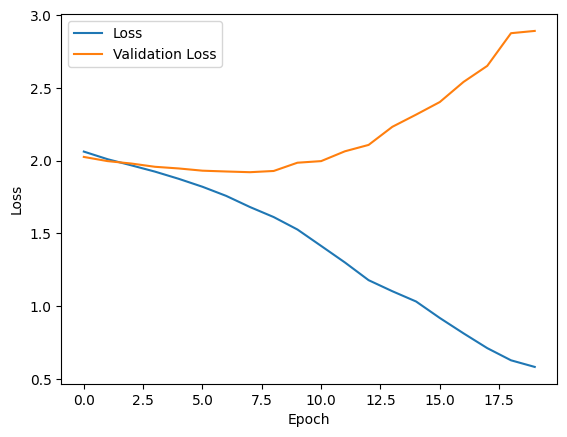

In [11]:
# Plot the loss for the training and validation
# Notice where the loss splits (overfitting)
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss, label="Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

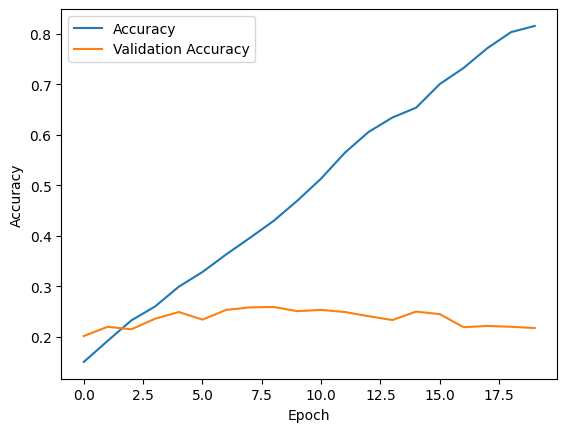

In [12]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.plot(accuracy, label="Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [13]:
# load the weights of the best model back in
model.load_weights(weights_file)

# Prepare y_test set with labels
new_y_test = enc.transform(y_test)
test_loss, test_acc = model.evaluate(x_test,new_y_test)
print('test accuracy', test_acc)

38/38 [==============================] - 0s 6ms/step - loss: 1.8975 - accuracy: 0.2867
test accuracy 0.2866666615009308


In [14]:
# go through all the results and check for top 3
y_pred = model(x_test)
k = 3
y_pred_top_k = np.argpartition(y_pred, -k)[:,-k:]
hello = new_y_test[:,np.newaxis]
diff = y_pred_top_k - hello
new = np.invert(np.all(diff, 1))
acc = new.mean()
print(acc)

0.6075


# Sample Song and Classification

In [15]:
tracks = utils.load('Data/tracks.csv')
genre = tracks['track']['genre_top']

In [25]:
test_val = 145600

first_val = True
while True:
  try:
    sid = str(test_val).zfill(6)

    ipd.display(ipd.Audio(f'Data/{sid}.mp3', autoplay=True))
    song_npy = np.load(f'MFCCS/{sid}.npy')

    if not first_val:
      print("Using", test_val, "instead")
    
    predictions = model.predict(song_npy[np.newaxis,:,:])[0]

    genre_actual = genre[int(test_val)]
    print("Actual genre:", genre_actual)

    lbl = np.unique(new_y_train, return_index=True)[1]
    lbl2 = [new_y_train[index] for index in sorted(lbl)] # genres encoded
    lbl3 = [y_train[index] for index in lbl] # genres strings

    # print("Predictions:", predictions)
    print("Top prediction:", lbl3[list(predictions).index(max(predictions))])

    for i in range(len(predictions)):
      print(f"{lbl3[i]:>15} : {predictions[i]*100:>8.3f}%")
    break

  except:
    if first_val:
      print(test_val, "not found. Trying next possible number")
      first_val = False
    test_val += 1
    continue

145600 not found. Trying next possible number


Using 145606 instead
1/1 [==============================] - 0s 30ms/step
Actual genre: Rock
Top prediction: Rock
     Electronic :    7.380%
   Experimental :   13.139%
           Folk :    7.174%
        Hip-Hop :    8.299%
   Instrumental :   10.355%
  International :    5.712%
            Pop :   15.587%
           Rock :   32.353%
